# Parse the signals according to TTL signal

Biosignals are recorded continuously. From the moment the participant is installed on the scanner's table and the electrodes are placed on him/her to the end of the scanning session. We want to keep the portions of the signal that correspond to when fMRI scanner is ON. We can monitor these segments thanks to the synchronization channel, i.e. the trigger channel, or TTL.

## Import packages and specify path

In [1]:
import pandas as pd
import neurokit as nk

In [2]:
dir_path = 'C:\\Users\\sangfrois\\physiological-signals\\original-data\\'
subject_path = 'sub-01\\'
exp_path = 'ses-video001\\'

## Read the signal and push in DataFrame

In [3]:

Biosignals_dataFrame, sampling_rate = nk.read_acqknowledge(dir_path+subject_path+exp_path+'sub-01_ses-video001-ocean11.acq', return_sampling_rate=True)


In [5]:
print(sampling_rate)

5000.0


### Define channels and look at the TTL

In [6]:
# associate dict keys to variable names and get a sense of the content with .describe()
ppg = Biosignals_dataFrame['PPG100C']
ecg = Biosignals_dataFrame['ECG100C']
rsp = Biosignals_dataFrame['Custom, HLT100C - A 6']
ttl = Biosignals_dataFrame['TTL']
eda = Biosignals_dataFrame['GSR-EDA100C-MRI']


Populating the interactive namespace from numpy and matplotlib


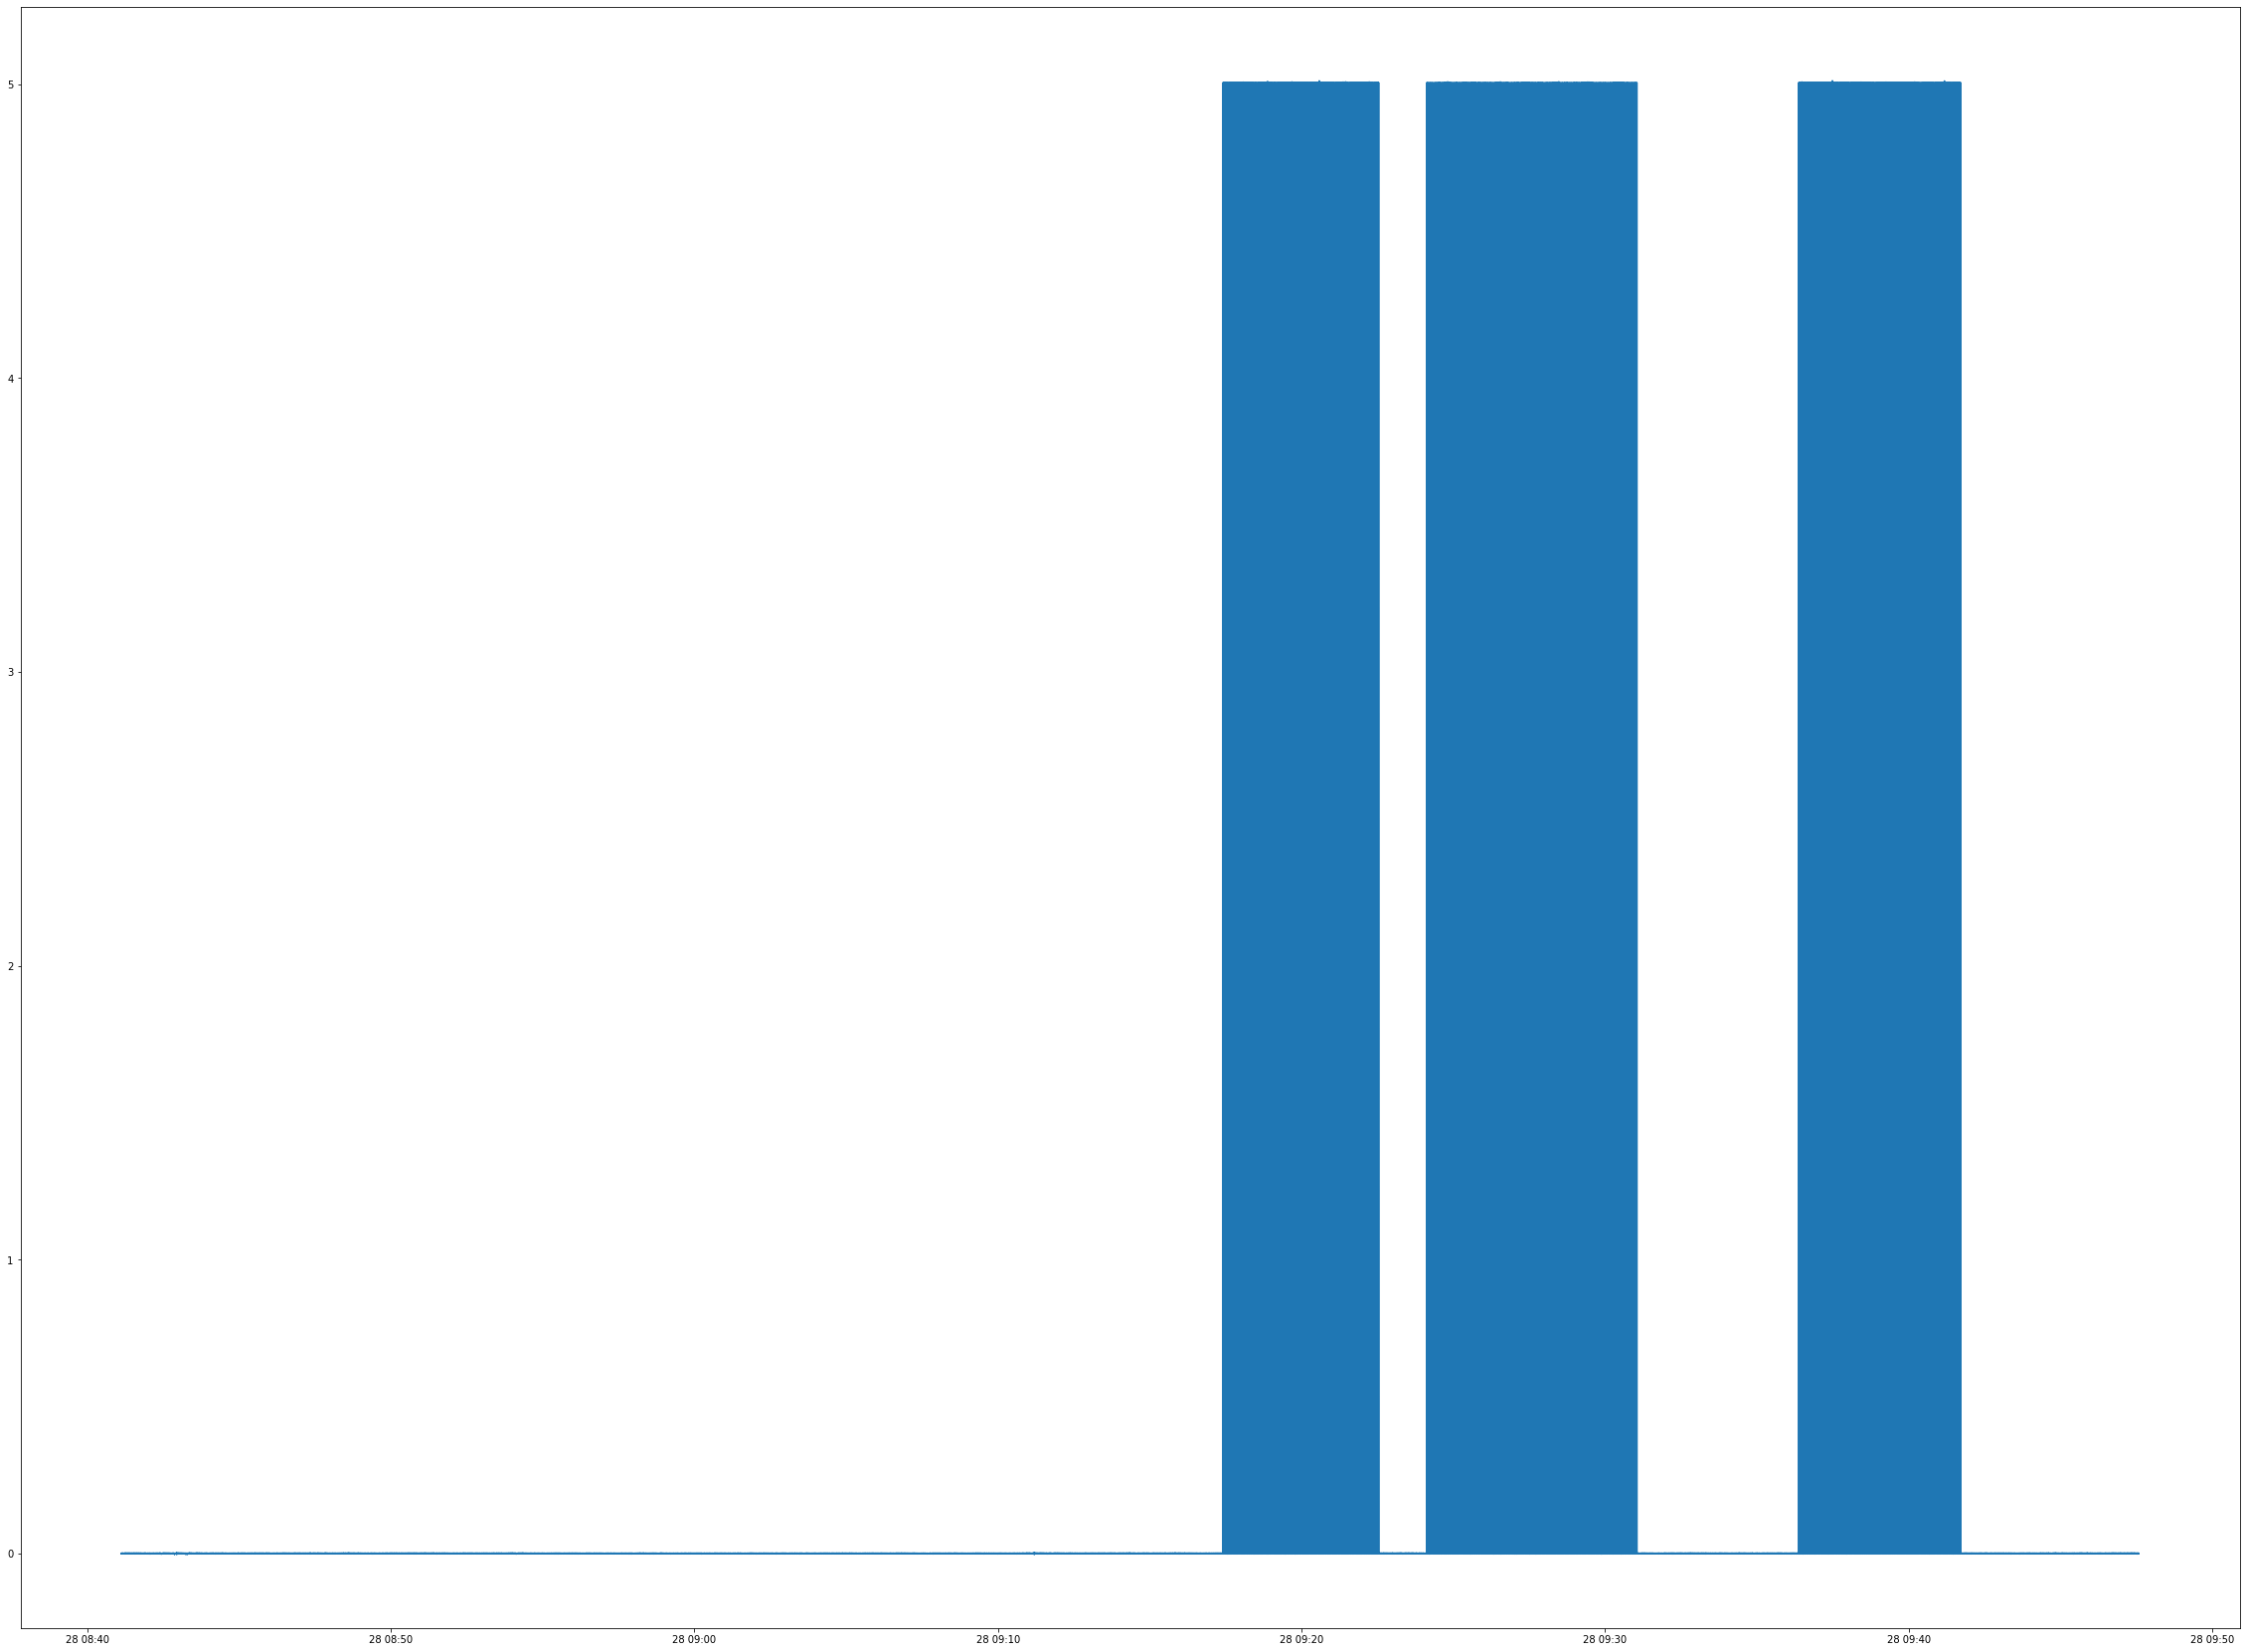

In [7]:
# Look at the TTL
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Make figures a bit bigger
%pylab inline
pylab.rcParams['figure.figsize'] = (40.0, 30.0)  

plt.plot(ttl)

### Define start and end for  the recording session
#### Neurokit uses timestamps as indexes, so we have to manipulate them with the proper package, i.e. DateTime

* ___query_df___ represents every datapoints where TTL channel values are higher than 1, i.e. __the scanner is on__

* Problem is that we can't just take these indexes because __the period between two rows represents the repetition time__ of the scanner's triggers

* TTL values can be high when doing structural (T1) sequences, i.e. around 5 mins

* TTL values can be high when doing BOLD (T2) sequences, i.e. should be 10 mins

*Start* and *End* represent the whole sanning session

*Delta_session* represents the length between the start and end time points

*block_len* is the a priori known minimum scanning block length


In [8]:
import datetime
from datetime import timedelta

query_df = Biosignals_dataFrame.query('TTL > 1')

start, end = query_df.index[[0, -1]]

delta_session = end-start
block_len = timedelta(minutes = 3)

query_df.head()

,GSR-EDA100C-MRI,PPG100C,ECG100C,TTL,"Custom, HLT100C - A 6"
2019-08-28 09:17:24.505581,7.528687,-0.079041,0.260315,5.003662,0.395508
2019-08-28 09:17:24.505781,7.530213,-0.078125,0.269012,5.002136,0.396118
2019-08-28 09:17:24.505981,7.527161,-0.078735,0.277557,5.003662,0.396423
2019-08-28 09:17:24.506181,7.533265,-0.079346,0.286407,5.004578,0.393677
2019-08-28 09:17:24.506381,7.531739,-0.079041,0.295105,5.004272,0.395203


In [9]:
len(query_df)

8978

In [10]:
len(Biosignals_dataFrame)

19940216

##### Comparison of both dataframes length
Less information to process, so the using the query dataframe to define parsing timepoints is more appropriate.
Next, we want to look for large difference between successive timepoints

### Define parsing indexes

1. If delta is over a priori known length of block, then query_df has multiple blocks
2. For each timestamps in query_df, substract the next time to the current time
    1. If difference time (time_delta) value is larger than TR period between two adjacent time points ; pushes both timestamps in a list
    2. else : ***error*** -- to be added
3. Else, there is only one block in the recording sesssion.
    

In [11]:
parse_list = []

if delta_session > block_len:
    
    tr_period = timedelta(seconds = 2)

    for time in range (len(query_df)-1) :
        
        time_delta = pd.to_datetime(query_df.index[time+1])-pd.to_datetime(query_df.index[time])
        
        if time_delta > tr_period:
            
            parse_start = pd.to_datetime(Biosignals_dataFrame.query('TTL > 1').index[time])
            parse_end = pd.to_datetime(Biosignals_dataFrame.query('TTL > 1').index[time+1])
            
            parse_list += [(parse_start, parse_end)]
        
    
    #Slice mutliple indexes
    #df.loc[('cobra', 'mark i'):('viper', 'mark ii')]
else:
        parse_list += [(start, end)]
print(parse_list)

[(Timestamp('2019-08-28 09:22:32.478597'), Timestamp('2019-08-28 09:24:07.409601')), (Timestamp('2019-08-28 09:31:03.022822'), Timestamp('2019-08-28 09:36:23.143838'))]


#### We end up with a list of Timestamps that goes like this :

parse_list = [(end of fMRI sequence, start of next), (start of next sequence, end of next), etc.]

**remember, we still have _start_ and _end_ timestamps, that corresponds to beginning and end of the whole recording session**

### Keep the first segment before scanner is turned on and name blocks based on Timestamp list

* Block00 is always first index of Biosignal_dataframe to the last index of parse_list; **Biosignal_dataframe.index[0]** 'till **start**

* Block 01 is always from start to first index of parse_list ; **start** 'till **first index of parse_list**

* BlockLast is always last index of parse_list to end ; **parse_list[i][i]** 'till **end**

#### Define each blocks in the initial Biosignal dataframe

* For each block (after block0 and block1), *START* timestamp parsing is equivalent to the second timestamp of the i _th_ element in parsing_list. And *END* timestamp parsing is equivalent to the first timestamp of the next element in parsing_list
* After, add last block with last element of parsing list until end

In [25]:
block0 = Biosignals_dataFrame[Biosignals_dataFrame.index[0]:start]
block1 = Biosignals_dataFrame[start:parse_list[0][0]]
block2 = Biosignals_dataFrame[parse_list[0][1]:parse_list[1][0]]
blockLast = Biosignals_dataFrame[parse_list[1][1]:end]


#blocks = [ block0, block1 ]
#for i in range(len(parse_list)):
 #   blocks += 'block'+(i+2)=[Biosignals_dataFrame[parse_list[i][1]:parse_list[1+i][0]]] 


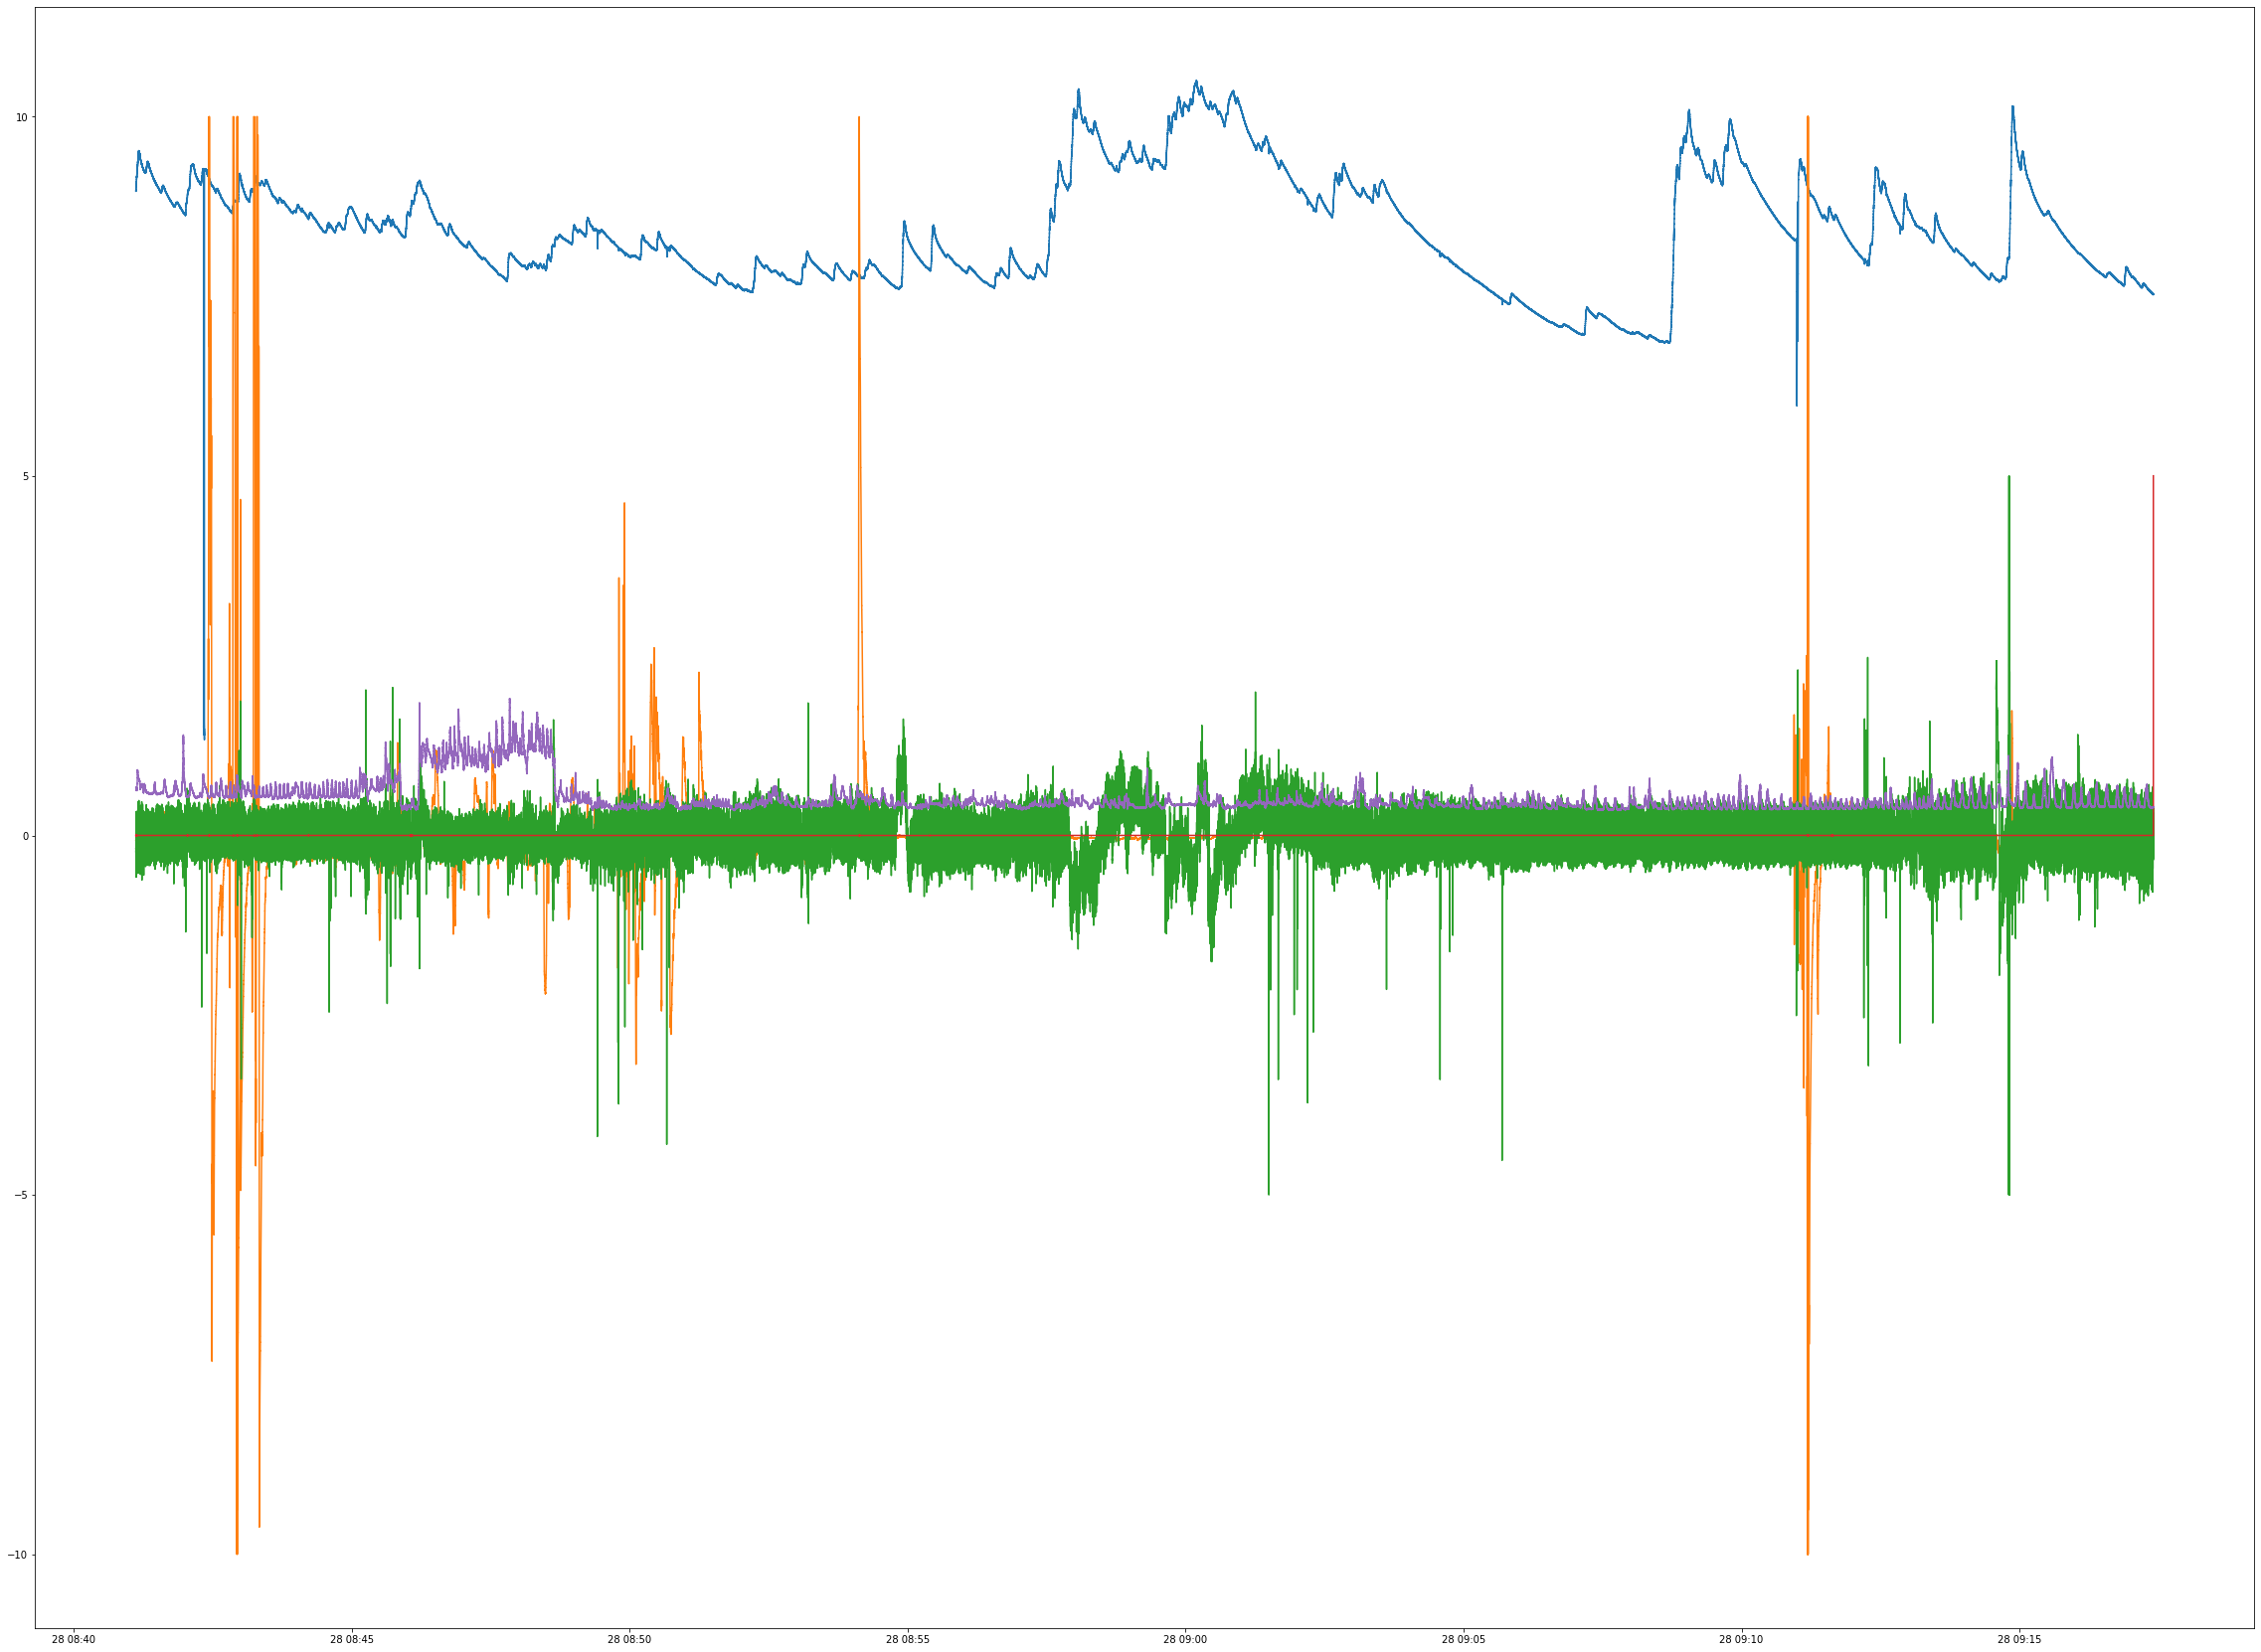

In [20]:
plt.plot(block0)

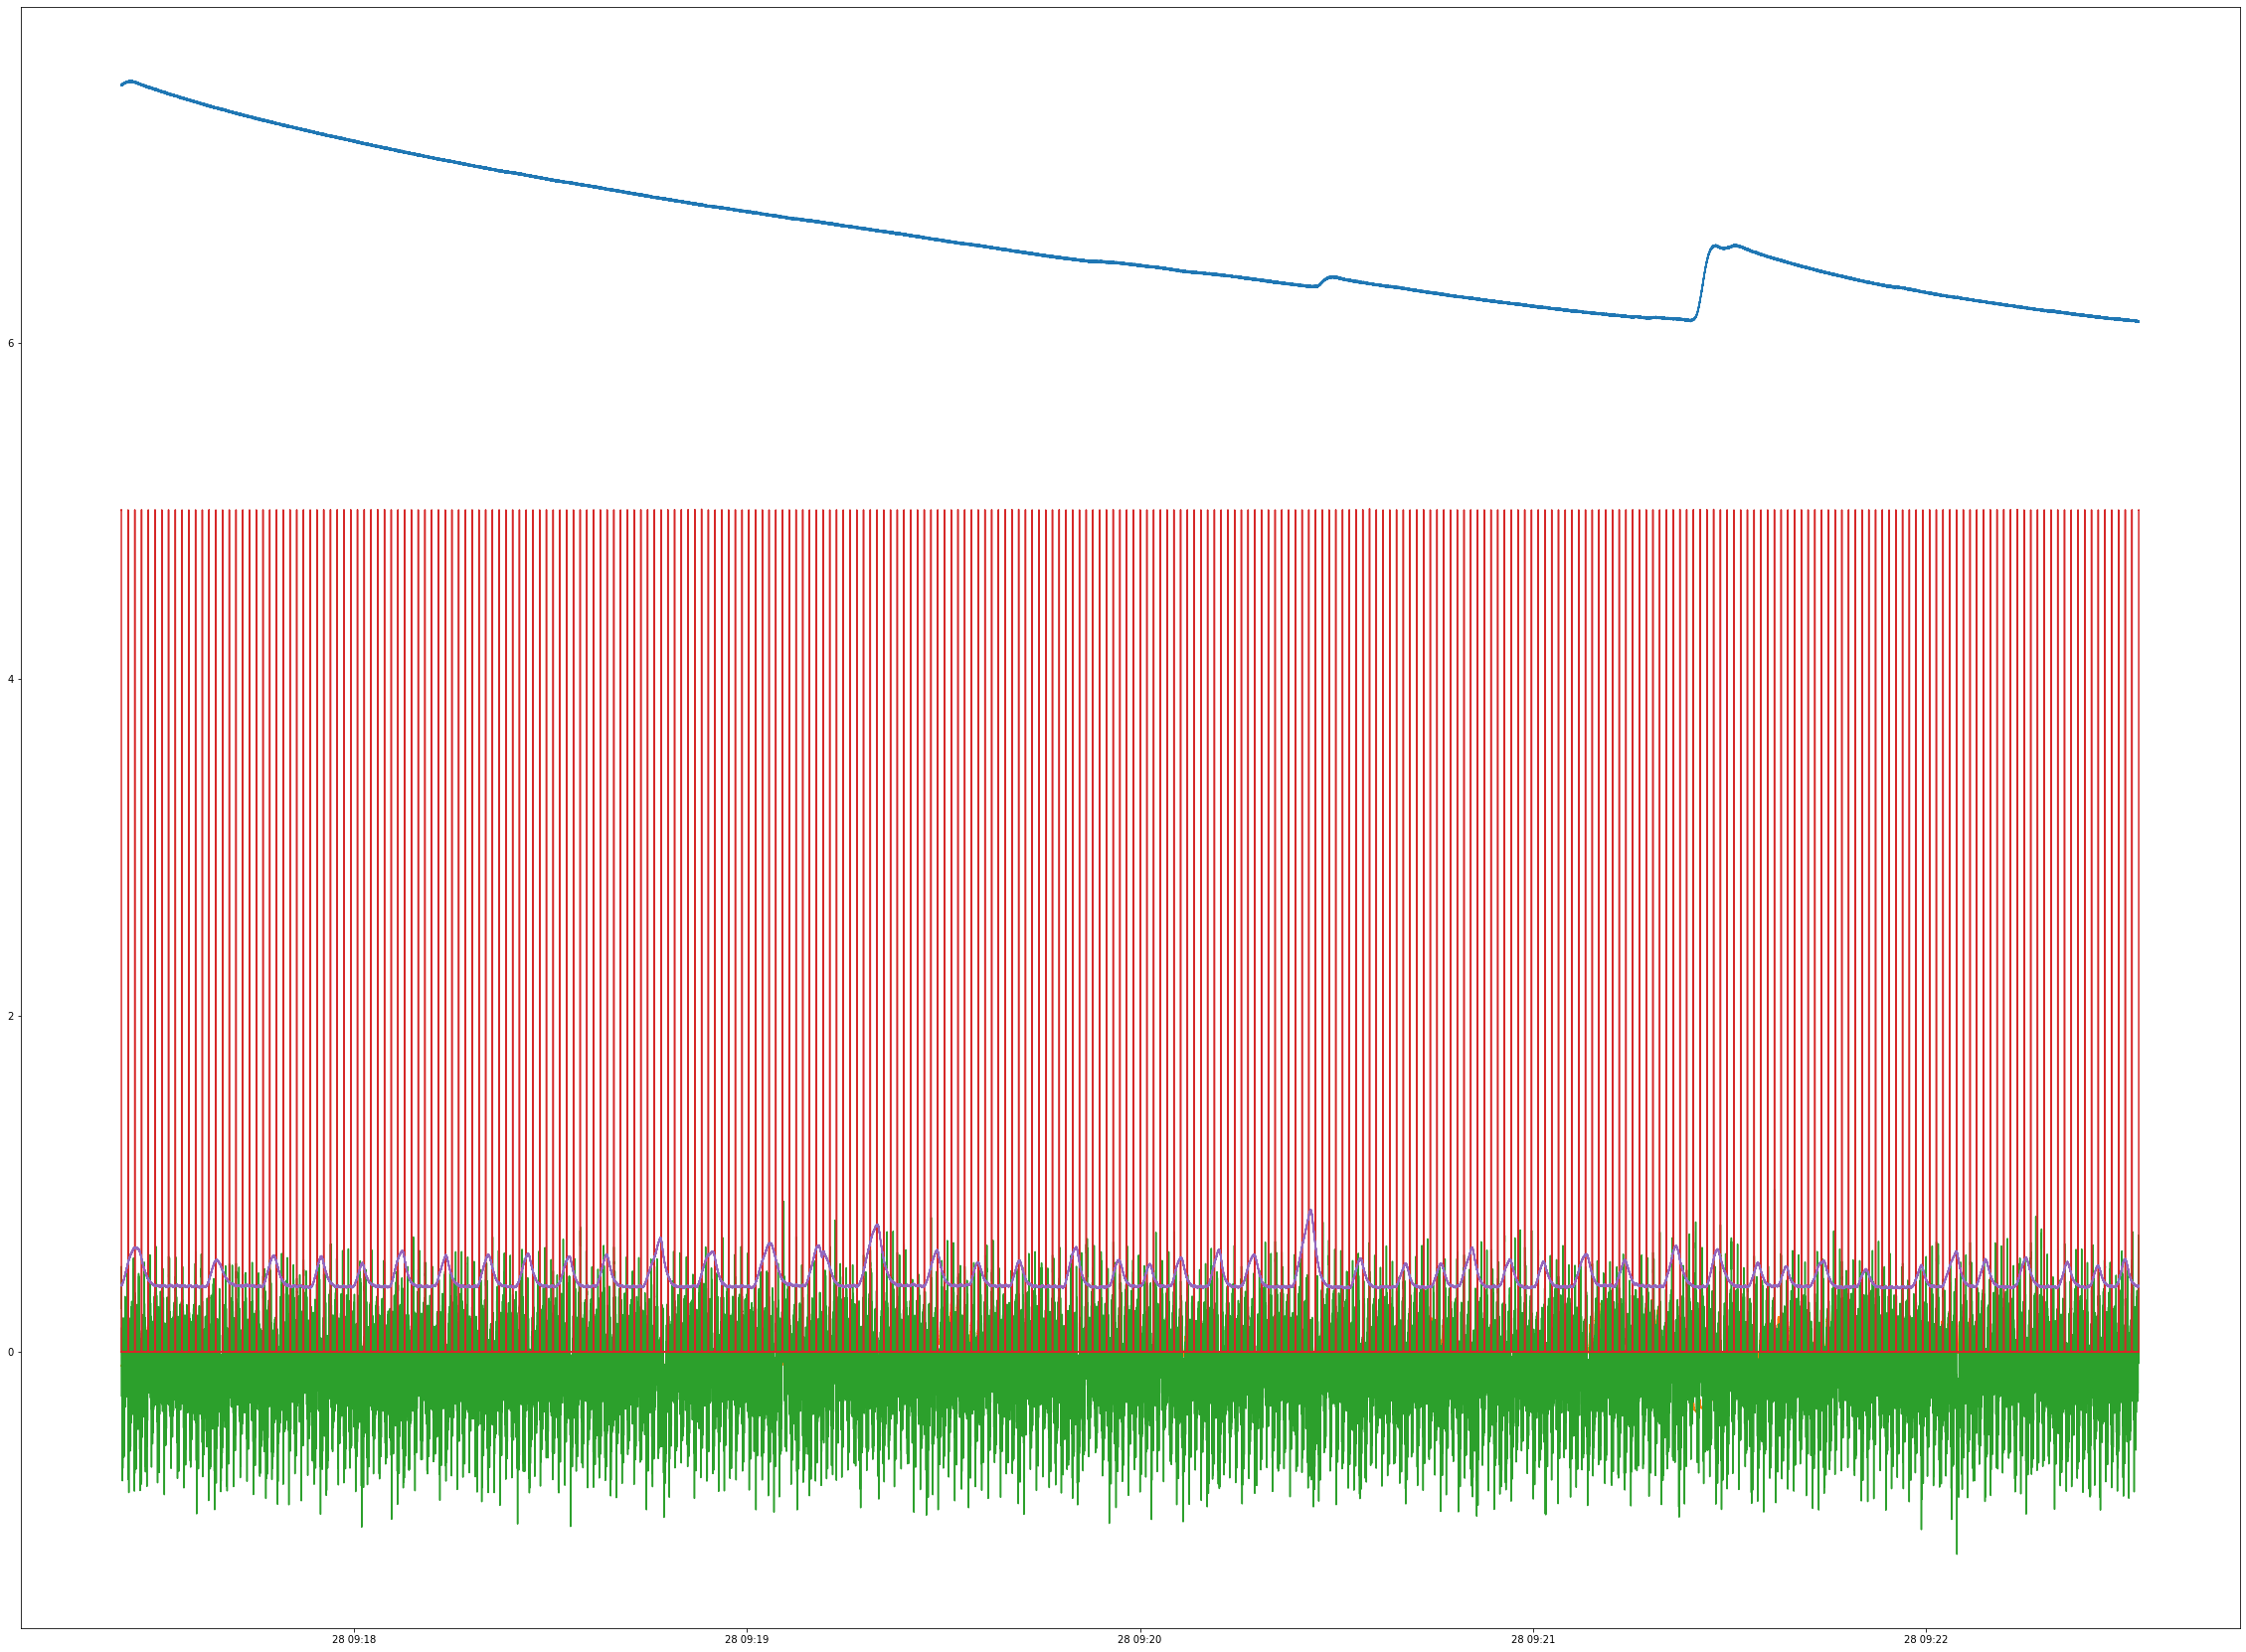

In [23]:
plt.plot(block1)

## Then, save the blocks with Pickle

In [17]:
import pickle
for i in blocks:
    pickle.dump(i, open( "sub-01_sesvideo0001_ocean11.pkl", "wb" ) )